# Introduction to Argoverse-tracking

This is a simple tutorial that will show you how to interact with the Argoverse-tracking dataset using our python package. See [github page](https://github.com/argoai/argoverse-api) for instructions on how to install the package.

Argoverse dataset can be download at [https://www.argoverse.org](https://www.argoverse.org) This tutorial assumes that you already download and extract all neccessary data into a specific folder 

## Data loading 

To load up the data, first we need to create the Argoverse tracking loader. This requires you to specify the path to the data directory.

In [10]:
import argoverse
from argoverse.data_loading.argoverse_tracking_loader import ArgoverseTrackingLoader

##set root_dir to the correct path to your dataset folder
root_dir =  '/home/alex/tracking/argoverse-api/sample'

argoverse_loader = ArgoverseTrackingLoader(root_dir)

print('Total number of logs:',len(argoverse_loader))
argoverse_loader.print_all()

Total number of logs: 1
#images: 3439
#lidar: 156


Argoverse-Tracking dataset provide raw data collected from actual self driving car session. We call each session `log`. For example, here is the list of the first 3 logs in our dataset.

In [11]:
argoverse_loader.log_list[0:3]

['c6911883-1843-3727-8eaa-41dc8cda8993']

One way to go through each log in our dataset is by iterating through our data loader. For example, we can print out statistics for each log by simply enumerating over the loader and printing each element.

In [12]:
for i,argoverse_data in enumerate(argoverse_loader):
    if i>=3:
        break
    print(argoverse_data)
    


--------------------------------------------------------------------
------Log id: c6911883-1843-3727-8eaa-41dc8cda8993
--------------------------------------------------------------------
Time: 15.500850000000002 sec
# frame lidar (@10hz): 156
# frame ring camera (@30hz): 469
# frame stereo camera (@5hz): 78

Total images: 3439
Total bounding box: 9337
        


You can also use indices starting from 0 to access each log or use the log id directly via get(log_id).

In [4]:
argoverse_data = argoverse_loader[0]
print(argoverse_data)

argoverse_data = argoverse_loader.get('c6911883-1843-3727-8eaa-41dc8cda8993')
print(argoverse_data)


--------------------------------------------------------------------
------Log id: c6911883-1843-3727-8eaa-41dc8cda8993
--------------------------------------------------------------------
Time: 15.500850000000002 sec
# frame lidar (@10hz): 156
# frame ring camera (@30hz): 469
# frame stereo camera (@5hz): 78

Total images: 3439
Total bounding box: 9337
        

--------------------------------------------------------------------
------Log id: c6911883-1843-3727-8eaa-41dc8cda8993
--------------------------------------------------------------------
Time: 15.500850000000002 sec
# frame lidar (@10hz): 156
# frame ring camera (@30hz): 469
# frame stereo camera (@5hz): 78

Total images: 3439
Total bounding box: 9337
        


There are multiple types of data in Argoverse-Tracking:
* raw data from the sensors
* track label annotations
* map information.

## Visualization

Let's look at one specific log (identified by a `log_id`) at one specific frame (`idx`)


In [30]:
log_id = 'c6911883-1843-3727-8eaa-41dc8cda8993'#argoverse_loader.log_list[55]
idx = 150
camera = argoverse_loader.CAMERA_LIST[0]

import argoverse.visualization.visualization_utils as viz_util
argoverse_data = argoverse_loader.get(log_id)

city_name = argoverse_data.city_name
print(city_name)

PIT


In [31]:
print('-------------------------------------------------------')
print(f'Log: {log_id}, \n\tframe: {idx}, camera: {camera}')
print('-------------------------------------------------------\n')


-------------------------------------------------------
Log: c6911883-1843-3727-8eaa-41dc8cda8993, 
	frame: 150, camera: ring_front_center
-------------------------------------------------------



For each log, we annotate objects around the AV (autonomous vehicle). The following shows annotations on images and 3D point clouds:

In [32]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from argoverse.utils.cv2_plotting_utils import plot_bbox_polygon_cv2

 ------------------------------------------------------------------------
 ------------------------- Ring Cameras ---------------------------------
 ------------------------------------------------------------------------



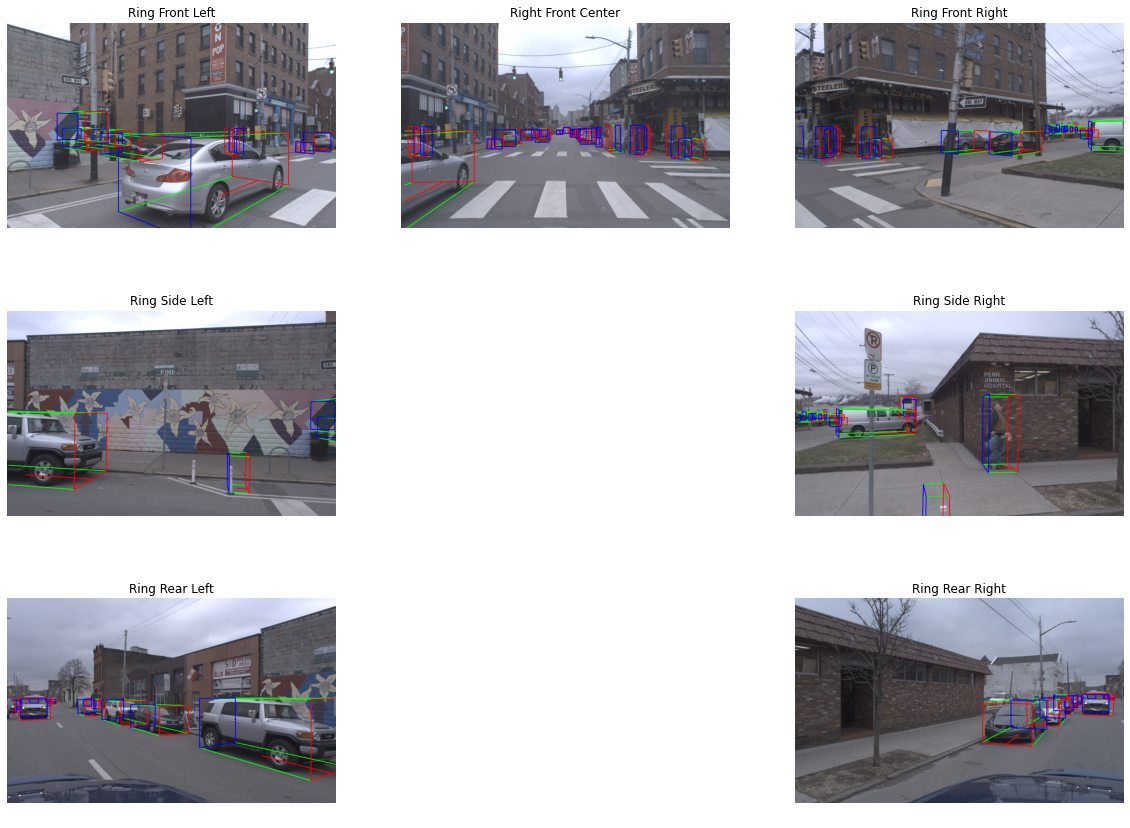

 ------------------------------------------------------------------------
 ------------------------- Point cloud ---------------------------------
 ------------------------------------------------------------------------



(-10.0, 10.0, -10.0, 10.0)

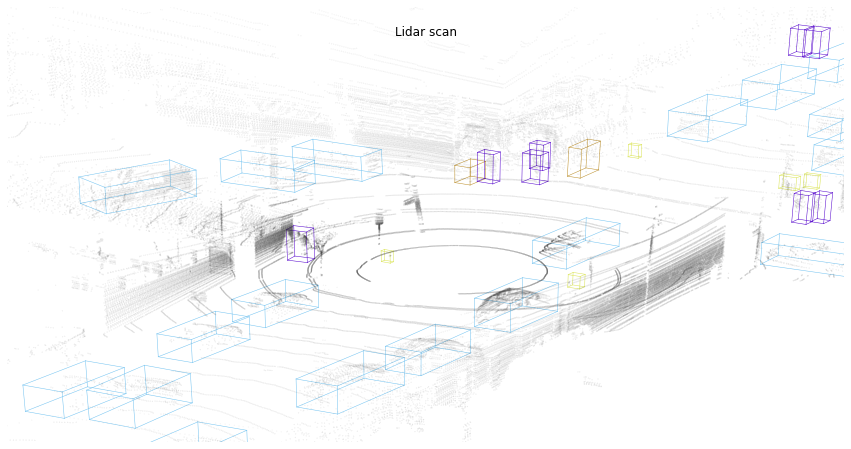

In [33]:

print(' ------------------------------------------------------------------------')
print(' ------------------------- Ring Cameras ---------------------------------')
print(' ------------------------------------------------------------------------\n')

f,ax = viz_util.make_grid_ring_camera(argoverse_data,idx)
plt.show()
print(' ------------------------------------------------------------------------')
print(' ------------------------- Point cloud ---------------------------------')
print(' ------------------------------------------------------------------------\n')

f2 = plt.figure(figsize=(15, 8))
ax2 = f2.add_subplot(111, projection='3d')  
   
viz_util.draw_point_cloud(ax2, 'Lidar scan',argoverse_data,idx)
ax2.axis('off')

### Synchronization

Even though the frequency of lidar sensor output is different than the camera's frame rate (10hz and 30 hz respectively), it's possible and easy to synchronize between them. While `argoverse_data.get_image_list` returns list of all images at 30hz, `argoverse_data.get_image_list_sync` returns a subset of image lists that sync with the lidar frames (10 hz).

We can do a lot of things with this, for example, projecting the point cloud into the image.

 ------------------------------------------------------------------------
 ----------------- Example of Lidar and Image synchronization-------------
 ------------------------------------------------------------------------



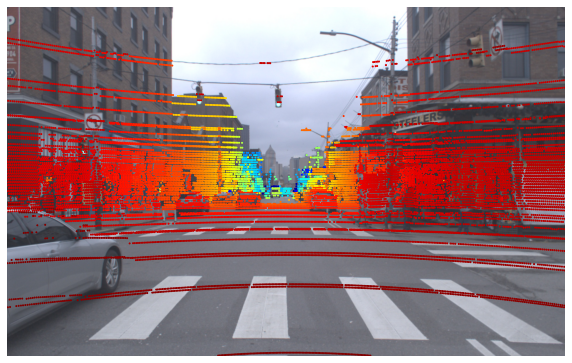

In [8]:
print(' ------------------------------------------------------------------------')
print(' ----------------- Example of Lidar and Image synchronization-------------')
print(' ------------------------------------------------------------------------\n')

img = argoverse_data.get_image_sync(idx,camera = camera)
objects = argoverse_data.get_label_object(idx)
calib = argoverse_data.get_calibration(camera)
img_vis = viz_util.show_image_with_boxes(img,objects,calib)
#display(Image.fromarray(img_vis))

pc = argoverse_data.get_lidar(idx)

uv = calib.project_ego_to_image(pc).T

idx_ = np.where(np.logical_and.reduce((uv[0, :] >= 0.0, uv[0, :] < np.shape(img)[1] - 1.0,
                                                      uv[1, :] >= 0.0, uv[1, :] < np.shape(img)[0] - 1.0,
                                                      uv[2, :] > 0)))
idx_ = idx_[0]
uv1 =uv[:, idx_]

if uv1 is None:
    raise Exception('No point image projection')
    
plt.figure(figsize=(10,30))
plt.imshow(img)
cm = plt.cm.get_cmap('jet')
plt.scatter(uv1[0], uv1[1], c=1 - uv1[2] / max(uv1[2]), s=1, cmap=cm)
plt.axis('off')
plt.show()    




## Tracking objects through time

The key aspect of our annotation is that the objects are tracked over time. We uniquely mark each object with a `tracking id`. This allows us to follow their trajectories throughout the log.

The following plot shows object trajectories from the start until the current frame. Each color represents a unique object.

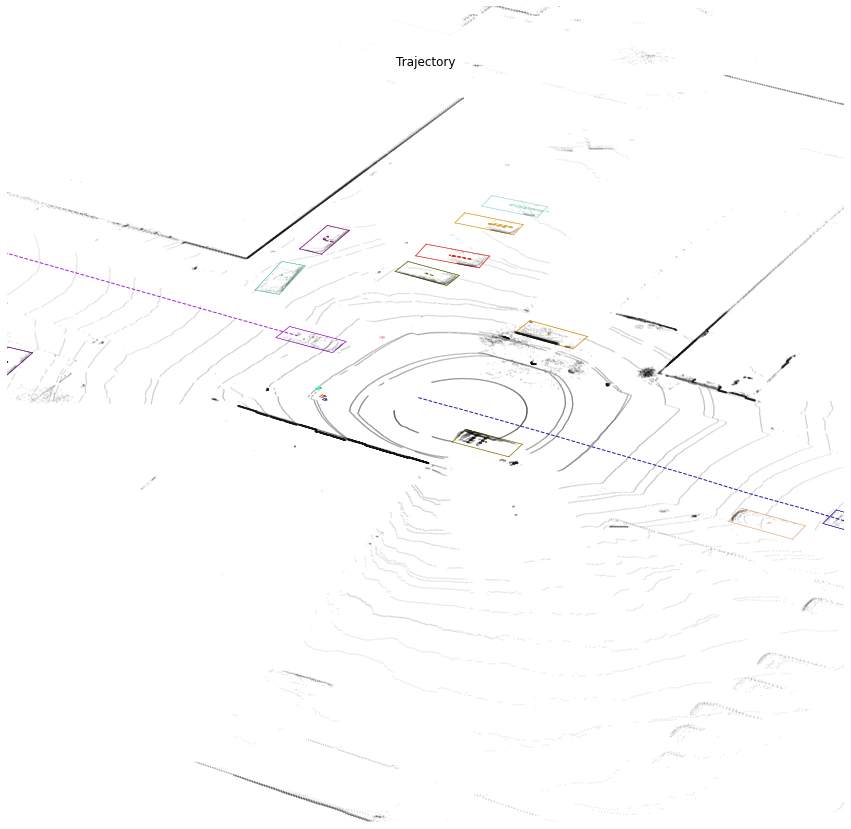

In [9]:
f3 = plt.figure(figsize=(15, 15))
ax3 = f3.add_subplot(111, projection='3d')  
idx=30 # current time frame
viz_util.draw_point_cloud_trajectory(
        ax3, 
        'Trajectory', 
        argoverse_data,idx,axes=[0, 1],xlim3d=(-15,15),ylim3d=(-15,15) # X and Y axes
    )
plt.axis('off')
plt.show()

## Using the map API

Argoverse also provides highly detailed map information, which is accessible via the `ArgoverseMap` class. See more in depth examples of how to use this class in [Map Demo](argoverse_map_tutorial.ipynb).